# Fine-grained Twitter Account Classification using Community Detection

#### Content

01. [Dataset](#Dataset)
02. [Network Generation](#Step-01:-Network-Generation)
03. [Community Detection using python library](#Community-Detection-using-python-library)
04. [Community Detection using computational mathematics](#Community-Detection-using-computational-mathematics)

## Dataset
| Dataset              | Bot   | Human  |
|----------------------|-------|--------|
| astroturf            | 585   |        |
| botwiki              | 704   |        |
| caverlee             | 22179 | 19276  |
| cresci-17            | 10894 | 3474   |
| gilani-17            | 1130  | 1522   |
| gregory_purchased    | 1088  |        |
| josh_political       | 62    |        |
| kevin_feedback       | 143   | 386    |
| midterm-2018         |       | 8092   |
| pronbots             | 21964 |        |
| rtbust               | 391   | 368    |
| stock                | 18508 | 7479   |
| varol-icwsm          | 826   | 1747   |
| verified             |       | 2000   |
| zoher-organization   |       | 21237  |
| **Total**            | **78474** | **65581** |


## Network Generation

In [4]:
import gzip

from bloc.generator import add_bloc_sequences
from bloc.subcommands import run_subcommands
from bloc.util import dumpJsonToFile
from bloc.util import get_bloc_params
from bloc.util import get_default_symbols
from bloc.util import getDictFromJson
from tqdm import tqdm

bot_dataset_files = [
    # {'src': 'astroturf', 'classes': ['political_Bot']},
    {'src': 'botwiki', 'classes': ['bot']}
    # {'src': 'caverlee', 'classes': ['bot']}
    # {'src': 'cresci-17', 'classes': ['bot-socialspam', 'bot-traditionspam', 'bot-fakefollower']},
    # {'src': 'gilani-17', 'classes': ['bot']},
    # {'src': 'gregory_purchased', 'classes': ['bot']},
    # {'src': 'josh_political', 'classes': ['bot']},
    # {'src': 'kevin_feedback', 'classes': ['bot']},
    # {'src': 'pronbots', 'classes': ['bot']},
    # {'src': 'rtbust', 'classes': ['bot']},
    # {'src': 'stock', 'classes': ['bot']},
    # {'src': 'varol-icwsm', 'classes': ['bot']}
]

human_dataset_files = [
    {'src': 'caverlee', 'classes': ['human']},
    {'src': 'cresci-17', 'classes': ['human']},
    {'src': 'gilani-17', 'classes': ['human']},
    {'src': 'kevin_feedback', 'classes': ['human']},
    {'src': 'rtbust', 'classes': ['human']},
    {'src': 'stock', 'classes': ['human']},
    {'src': 'varol-icwsm', 'classes': ['human']},
    {'src': 'verified', 'classes': ['human']},
    {'src': 'midterm-2018', 'classes': ['human']},
    {'src': 'zoher-organization', 'classes': ['human', 'organization']}
]


def get_user_id_class_map(file_path):
    user_id_class_map = {}
    all_classes = set()

    with open(file_path, 'r') as fd:
        for line in fd:
            parts = line.strip().split()
            if len(parts) >= 2:
                user_id, user_class = parts[0], parts[1]
                user_id_class_map[user_id] = user_class
                all_classes.add(user_class)

    return user_id_class_map, all_classes

def process_dataset(dataset_files, result_file_path):
    bloc_payload = []
    dataset_path = '../dataset/'
    for file in dataset_files:
        tweets_file_path = dataset_path + file['src'] + '/tweets.jsons.gz'
        userid_file_path = dataset_path + file['src'] + '/userIds.txt'
        user_id_class_map, all_classes = get_user_id_class_map(userid_file_path)

        with gzip.open(tweets_file_path, 'rt', encoding='windows-1252') as infile:
            for line in infile:
                line = line.split('\t')
                if user_id_class_map.get(line[0], '') in file['classes']:
                    tweets = getDictFromJson(line[1])
                    u_bloc = add_bloc_sequences(tweets, all_bloc_symbols=all_bloc_symbols, **gen_bloc_params)
                    bloc_payload.append(u_bloc)

    pairwise_sim_report = run_subcommands(gen_bloc_args, 'sim', bloc_payload)
    dumpJsonToFile(result_file_path, pairwise_sim_report, indentFlag=True)

all_bloc_symbols = get_default_symbols()
gen_bloc_params, gen_bloc_args = get_bloc_params([], '',
                                                 sort_action_words=True, keep_bloc_segments=True,
                                                 tweet_order='noop')

In [5]:
bot_result_file = 'results/pairwise_sim_report_bot.json'
# human_result_file = 'results/pairwise_sim_report_human.json'

process_dataset(bot_dataset_files, bot_result_file)
# process_dataset(human_dataset_files, human_result_file)

### Community Detection using python library

Number of communities: 22


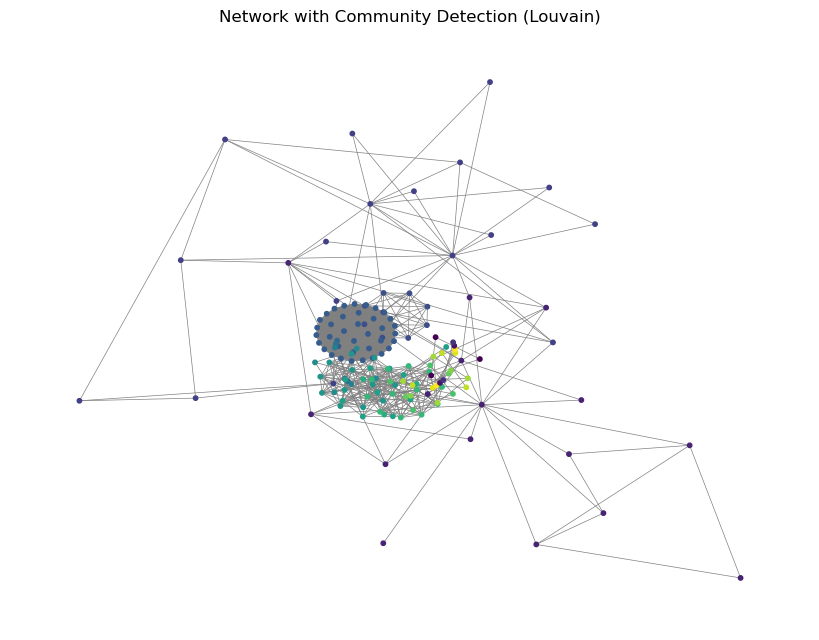

In [17]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import community

with open(bot_result_file, "r") as file:
    data = json.load(file)

# Create a graph
G = nx.karate_club_graph()

# Add nodes and edges based on similarity threshold
similarity_threshold = 1.00

for entry in data:
    if entry["sim"] >= similarity_threshold:
        user1, user2 = entry["user_pair"]
        G.add_node(user1)
        G.add_node(user2)
        G.add_edge(user1, user2, weight=entry["sim"])

# Perform community detection using the Louvain algorithm
partition = community.best_partition(G)

# Get the number of communities
num_communities = max(partition.values()) + 1
print("Number of communities:", num_communities)

# Visualize the network with community detection
plt.figure(figsize=(8, 6))
nx.draw_kamada_kawai(G, with_labels=False, node_size=10, node_color=list(partition.values()),
                     edge_color='gray', width=0.5)

# Customize the plot
plt.title("Network with Community Detection (Louvain)")
plt.axis("off")

# Display the plot
plt.show()

## Community Detection using computational mathematics

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

def modularity(G, partition):
    
    # Get the total number of edges in the graph
    m = G.number_of_edges()
    
    # Initialize modularity to zero
    Q = 0
    
    # Iterate over unique community labels in the partition
    for community in set(partition.values()):
        # Get nodes belonging to the current community
        nodes_in_community = [node for node, comm in partition.items() if comm == community]
        
        # Create a subgraph containing only the nodes in the current community
        subgraph = G.subgraph(nodes_in_community)
        
        # Calculate the number of edges within the current community
        L_c = subgraph.number_of_edges()
        
        # Calculate the sum of degrees of nodes in the current community
        d_c = sum(dict(G.degree(nodes_in_community)).values())
        
        # Update modularity using the formula for each community
        Q += (L_c / (2 * m)) - ((d_c / (2 * m))**2)
    
    # Return the overall modularity of the partition
    return Q

In [19]:
def louvain_algorithm(G):
    
    # Initialize each node in its own community
    partition = {node: node for node in G.nodes}
    
    # Calculate modularity for the initial partition
    modularity_history = [modularity(G, partition)]

    # Continue iterating until modularity no longer improves
    while True:
        for node in G.nodes:
            # Get the current community label of the node
            current_community = partition[node]
            
            # Initialize variables to track the best community, and maximum modularity gain
            best_community = current_community
            max_modularity_gain = 0

            # Get the neighbors of the current node
            neighbors = list(G.neighbors(node))
            
            # Calculate the size of the current community
            current_community_size = sum(1 for n in G.nodes if partition[n] == current_community)

            # Iterate over unique neighbors
            for neighbor in set(neighbors):
                # Calculate the size of the community to which the neighbor belongs
                neighbor_community_size = sum(1 for n in G.nodes if partition[n] == partition[neighbor])
                
                # Calculate the modularity gain for moving the current node to the neighbor's community
                modularity_gain = (
                    (G.degree(node) / (2 * G.number_of_edges())) -
                    (neighbor_community_size / (2 * G.number_of_edges())) +
                    ((current_community_size - 1) / (2 * G.number_of_edges())) *
                    (1 - (neighbor_community_size / G.number_of_edges()))
                )

                # Update the best community if the modularity gain is greater
                if modularity_gain > max_modularity_gain:
                    max_modularity_gain = modularity_gain
                    best_community = partition[neighbor]

            # If a better community is found, move the node to that community
            if best_community != current_community:
                partition[node] = best_community

        # Calculate modularity for the updated partition
        modularity_value = modularity(G, partition)
        modularity_history.append(modularity_value)

        # Check if modularity no longer improves; if so, break the loop
        if modularity_value <= max(modularity_history[:-1]):
            break

    # Return the final partition with the highest modularity
    return partition


Number of communities: 82


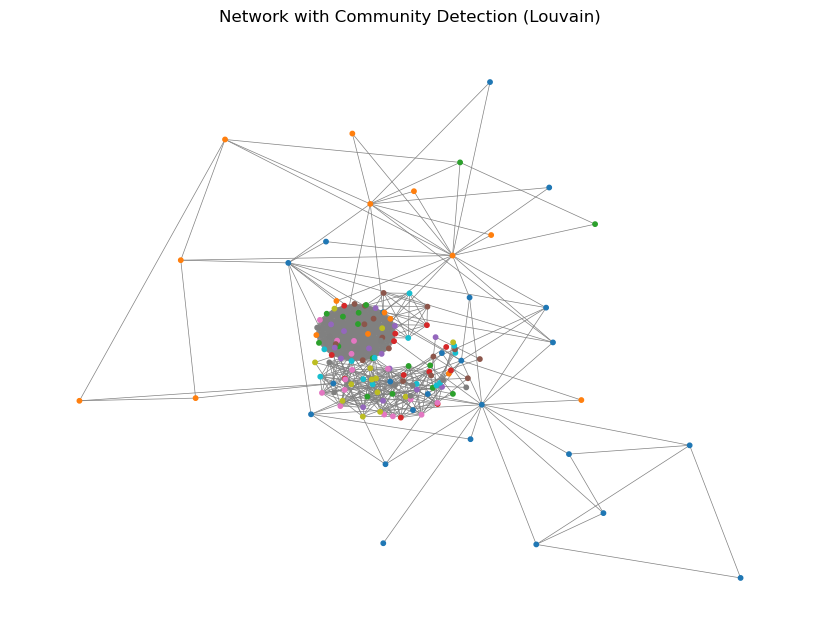

In [20]:
# Create a graph
G = nx.karate_club_graph()

json_file_path = "results/pairwise_sim_report_bot.json"
with open(json_file_path, "r") as file:
    data = json.load(file)
    
# Add nodes and edges based on similarity threshold
similarity_threshold = 1.00

for entry in data:
    if entry["sim"] >= similarity_threshold:
        user1, user2 = entry["user_pair"]
        G.add_node(user1)
        G.add_node(user2)
        G.add_edge(user1, user2, weight=entry["sim"])

# Perform Louvain community detection
final_partition = louvain_algorithm(G)

# Get the number of communities
num_communities = len(set(final_partition.values()))
print("Number of communities:", num_communities)

# Map community names or usernames to numeric labels
community_mapping = {community: idx for idx, community in enumerate(set(final_partition.values()))}

# Convert community labels to numeric labels
numeric_labels = [community_mapping[final_partition[node]] for node in G.nodes()]

# Visualize the network with community detection using Kamada-Kawai layout
plt.figure(figsize=(8, 6))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, node_color=numeric_labels, cmap=plt.cm.tab10, node_size=10, edge_color='gray', width=0.5)

# Customize the plot
plt.title("Network with Community Detection (Louvain)")
plt.show()
